# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [0]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt


In [0]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/nlp_project")
os.getcwd() 

import urllib.request
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1) Monolingual (English) word embeddings 

In [0]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        
        #verify if word is in our vocabulary
        if not (word in self.words): raise ValueError('Word must be in the vocabulary: ', word)
        
        word_id = self.word2id[word]
        return(self.embeddings[word_id])
        
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        #raise NotImplementedError('Fill in the blank')
        embdg1 = self.encode(word1)
        embdg2 = self.encode(word2)
        norm1 = np.linalg.norm(embdg1)
        norm2 = np.linalg.norm(embdg2)
        return(np.dot(embdg1,embdg2)/(norm1*norm2))
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort 
        
        #compute score with every word of the vocabulary
        simiarities = np.array([self.score(word, word1) for word1 in self.words])
        most_sim_id=np.argsort(simiarities)[::-1][1:k+1]
        
        return(np.array([self.id2word[idx] for idx in most_sim_id]))

In [0]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word))

In [0]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        D=len(sentences)
        idf={}
        occ_word={}
        for line in tqdm(sentences):
            for word in line.strip().split(' '):
                occ_word[word]=occ_word.get(word,0)+1
        for word in tqdm(occ_word.keys()):
                idf[word] = np.log(D/occ_word[word])
        return(idf)  
        
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        if idf is None:
            # mean of word vectors
            word_vec = np.array([self.word2vec.encode(word) for word in sentence.strip().split(' ') if word in self.word2vec.words])
            return(np.mean(word_vec ,axis=0))
        else:
            # idf-weighted mean of word vectors
            word_vec = np.array([idf[word]*self.word2vec.encode(word) for word in sentence.strip().split(' ') if word in self.word2vec.words])
            return(np.mean(word_vec,axis=0))
            
    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        embdg1 = self.encode(sentence1)
        embdg2 = self.encode(sentence2)
        norm1 = np.linalg.norm(embdg1)
        norm2 = np.linalg.norm(embdg2)
        return(np.dot(embdg1,embdg2)/(norm1*norm2))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = np.vstack([self.encode(sentence, idf) for sentence in sentences])
        score_keys=np.argsort([np.dot(query,key)/(np.linalg.norm(query)* np.linalg.norm(key)) for key in keys])[::-1][1:k+1]
        return([sentences[idx] for idx in score_keys])

In [0]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]

print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [0]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        X=[]
        Y=[]
        common_words=list(set(self.fr_word2vec.words)&set(self.en_word2vec.words))
        for word in common_words:
            X.append(fr_word2vec.encode(word))
            Y.append(en_word2vec.encode(word))
        X=np.vstack(X).T
        Y=np.vstack(Y).T
        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        
        U, S, V = np.linalg.svd(Y@X.T)
        W = U@V
        assert W.shape == (300, 300)
        return np.matmul(self.fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word
        
        #Get target encoding of the french word
        word_id = self.fr_word2vec.word2id[fr_word]
        target_embd= self.aligned_fr_embeddings[word_id]
        
        #function to compute the cosine similarity score
        score = lambda en_word: np.dot(target_embd,self.en_word2vec.encode(en_word))/(np.linalg.norm(target_embd)*np.linalg.norm(self.en_word2vec.encode(en_word)))
       
        #compute score with every word of the vocabulary
        simiarities = np.array([score(en_word) for en_word in self.en_word2vec.words])
        most_sim_id = np.argsort(simiarities)[::-1][1:k+1]
        
        return(np.array([self.en_word2vec.id2word[idx] for idx in most_sim_id]))

In [0]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [0]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

def load_train(filepath):
    labels = []
    sentences = []
    with open(filepath) as f:
        for line in f:
            label,sentence=line.strip('\n').split(' ',1)
            labels.append(label)
            sentences.append(sentence)
    return(sentences,labels)


def load_test(filepath):
    sentences = []
    with open(filepath) as f:
        for line in f:
            sentence=line.strip('\n')
            sentences.append(sentence)
    return(sentences)

sentences_train, label_train = load_train(train_filepath)
sentences_dev, label_dev = load_train(dev_filepath)
sentences_test = load_test(test_filepath)

In [0]:
# 2 - Encode sentences with the BoV model above

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

idf_train = sentence2vec.build_idf(sentences_train)
idf_dev = sentence2vec.build_idf(sentences_dev)
idf_test = sentence2vec.build_idf(sentences_test)

def encode_sentences(sentences,idf=None):
    X=[]
    for sentence in sentences:
        embd = sentence2vec.encode(sentence, idf)
        X.append(embd)
    return(np.vstack(X))

#Encode with the average of word vectors
X_train = encode_sentences(sentences_train)
X_dev = encode_sentences(sentences_dev)
X_test = encode_sentences(sentences_test)

#Encore with the weighted-average
X_train_idf = encode_sentences(sentences_train, idf_train)
X_dev_idf = encode_sentences(sentences_dev, idf_dev)
X_test_idf = encode_sentences(sentences_test, idf_test)

  0%|          | 0/8544 [00:00<?, ?it/s]

Loaded 50000 pretrained word vectors


100%|██████████| 7929/7929 [00:00<00:00, 505796.66it/s]


In [0]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

from sklearn.linear_model import LogisticRegression
print("Encode with the average of word vectors")
clf = LogisticRegression(random_state=0,max_iter = 2000).fit(X_train, label_train)
print("Score on train:",clf.score(X_train, label_train))
print("Score on dev:",clf.score(X_dev, label_dev))

print()

print("Encore with the weighted-average")
clf = LogisticRegression(random_state=0,max_iter = 2000).fit(X_train_idf, label_train)
print("Score on train:",clf.score(X_train_idf, label_train))
print("Score on dev:",clf.score(X_dev_idf, label_dev))

In [0]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

prediction = clf.predict(X_test_idf)
print(prediction)

print(prediction[-1], sentences_test[-1])

def write_prediction(classifier_name, prediction):
    f = open("{}_bov_y_test_sst.txt".format(classifier_name), "w")
    for pred in prediction:
        f.write(pred)
        f.write('\n')
    f.close()

write_prediction('logreg', prediction)

In [0]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, label_train)
    score = clf.score(X_train, label_train)
    print(name,' train: ',score)
    score = clf.score(X_dev, label_dev)
    print(name,' dev: ',score)
    prediction = clf.predict(X_test)
    write_prediction(name, prediction)
    

# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [0]:
import tensorflow as tf

In [0]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

def preprocess(data):
  new_data=[]
  for x in data:
    new_data.append(tf.keras.preprocessing.text.one_hot(x, 50000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' '))
  return(new_data)

X_train = preprocess(sentences_train)
X_dev = preprocess(sentences_dev)
X_test = preprocess(sentences_test)

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [0]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

def preprocess_pad(data):
  maxlen = max([len(x) for x in data])
  return(tf.keras.preprocessing.sequence.pad_sequences(data, maxlen=None))

x_train = preprocess_pad(X_train)

y_train = np.array(label_train).astype(int)
y_train = tf.keras.utils.to_categorical(y_train)#Categorical binary vectorization

x_dev = preprocess_pad(X_dev)
y_dev = np.array(label_dev).astype(int)
y_dev = tf.keras.utils.to_categorical(y_dev)#Categorical binary vectorization

x_test = preprocess_pad(X_test)

## 4.2 - Design and train your model

In [0]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization,TimeDistributed, Conv1D, MaxPooling1D

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()

model.add(Embedding(vocab_size, embed_dim))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(n_classes, activation='sigmoid'))


In [0]:
# 4 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW
              

loss_classif     =   'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  tf.keras.optimizers.Adam(0.001) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          1600000   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 256)         24832     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 128)         98432     
_________________________________________________________________
dropout_21 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 64)          24640     
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 64)        

Train on 8544 samples, validate on 1101 samples
Epoch 1/20
8544/8544 [==============================] - 7s 827us/sample - loss: 1.7066 - acc: 0.2061 - val_loss: 1.5990 - val_acc: 0.2534
Epoch 2/20
8544/8544 [==============================] - 5s 626us/sample - loss: 1.6495 - acc: 0.2288 - val_loss: 1.5844 - val_acc: 0.2534
Epoch 3/20
8544/8544 [==============================] - 5s 623us/sample - loss: 1.6190 - acc: 0.2292 - val_loss: 1.5792 - val_acc: 0.2534
Epoch 4/20
8544/8544 [==============================] - 5s 619us/sample - loss: 1.5965 - acc: 0.2541 - val_loss: 1.5746 - val_acc: 0.2534
Epoch 5/20
8544/8544 [==============================] - 5s 638us/sample - loss: 1.5838 - acc: 0.2623 - val_loss: 1.5827 - val_acc: 0.2534
Epoch 6/20
8544/8544 [==============================] - 5s 620us/sample - loss: 1.5505 - acc: 0.2876 - val_loss: 1.5524 - val_acc: 0.3043
Epoch 7/20
8544/8544 [==============================] - 5s 627us/sample - loss: 1.4983 - acc: 0.3228 - val_loss: 1.5441 - va

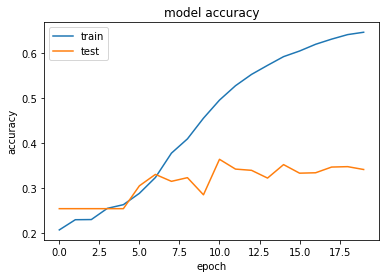

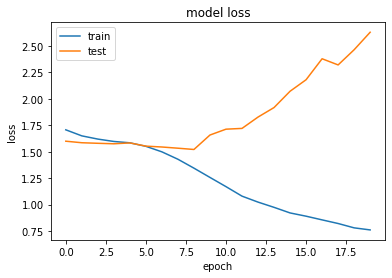

In [0]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs = 64
n_epochs = 20

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

predictions = model.predict(x_test).argmax(axis=1)

def write_prediction(classifier_name, prediction):
    f = open("{}_y_test_sst.txt".format(classifier_name), "w")
    for pred in prediction:
        f.write(str(pred))
        f.write('\n')
    f.close()

write_prediction('logreg_lstm', predictions)

## 4.3 - innovate !

  0%|          | 0/8544 [00:00<?, ?it/s]

Loaded 50000 pretrained word vectors


100%|██████████| 7929/7929 [00:00<00:00, 553649.80it/s]


Train on 8544 samples, validate on 1101 samples
Epoch 1/10
8544/8544 [==============================] - 2s 273us/sample - loss: 1.5576 - acc: 0.3048 - val_loss: 1.5252 - val_acc: 0.3006
Epoch 2/10
8544/8544 [==============================] - 1s 97us/sample - loss: 1.3833 - acc: 0.3851 - val_loss: 1.4251 - val_acc: 0.3560
Epoch 3/10
8544/8544 [==============================] - 1s 100us/sample - loss: 1.3371 - acc: 0.4102 - val_loss: 1.3625 - val_acc: 0.4078
Epoch 4/10
8544/8544 [==============================] - 1s 97us/sample - loss: 1.3030 - acc: 0.4235 - val_loss: 1.3433 - val_acc: 0.4005
Epoch 5/10
8544/8544 [==============================] - 1s 98us/sample - loss: 1.2757 - acc: 0.4364 - val_loss: 1.3496 - val_acc: 0.4151
Epoch 6/10
8544/8544 [==============================] - 1s 102us/sample - loss: 1.2574 - acc: 0.4449 - val_loss: 1.3399 - val_acc: 0.4015
Epoch 7/10
8544/8544 [==============================] - 1s 100us/sample - loss: 1.2231 - acc: 0.4607 - val_loss: 1.3577 - val_a

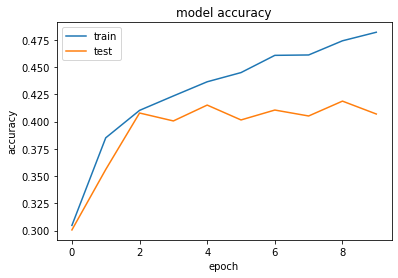

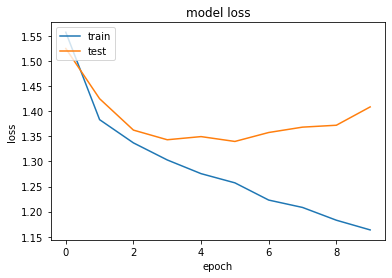

In [0]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.


word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

idf_train = sentence2vec.build_idf(sentences_train)
idf_dev = sentence2vec.build_idf(sentences_dev)
idf_test = sentence2vec.build_idf(sentences_test)

def encode_sentences(sentences,idf=None):
    X=[]
    for sentence in sentences:
        embd = sentence2vec.encode(sentence, idf)
        X.append(embd)
    return(np.vstack(X))


#Encore with the weighted-average
x_train = encode_sentences(sentences_train, idf_train)
x_dev = encode_sentences(sentences_dev, idf_dev)
x_test = encode_sentences(sentences_test, idf_test)

model = Sequential()
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='sigmoid'))

loss_classif     =   'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  tf.keras.optimizers.Adam(learning_rate=0.001) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

# ADAPT CODE BELOW
bs = 64
n_epochs = 10

history = model.fit(x_train, y_train, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev, y_dev))

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


predictions = model.predict(x_test).argmax(axis=1)

def write_prediction(classifier_name, prediction):
    f = open("{}_y_test_sst.txt".format(classifier_name), "w")
    for pred in prediction:
        f.write(str(pred))
        f.write('\n')
    f.close()

write_prediction('word2vec_dense', predictions)
